In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc

# Erez Steiner - NBA Shot Analysis

The purpose of this project is to analyze and visualize changes in the way basketball has been played in the last 2 decades in the NBA.

I decided to analyze the impact of the 3-point shot to see where it really started to take over the league, in addition to some general overview of the last 19 years in the NBA.
 
In addition, I will compare the earliest and latest seasons of LeBron James in the DB, 2005 and 2024, to further see how the NBA has changed in the last 2 decades.


# Extracting, Transforming, Loading the data

the following data contains information about all shot attempts over the last 20 years in the NBA's regular season (no playoff games are included)
this data DOES NOT hold information about freethrows(penalty shots)

In [2]:
#raw csvs can be downloaded here https://github.com/DomSamangy/NBA_Shots_04_24/tree/main
raw_folder_path = 'data\\raw'
folder_list = os.listdir(raw_folder_path)
print(folder_list)

['NBA_2004_Shots.csv', 'NBA_2005_Shots.csv', 'NBA_2006_Shots.csv', 'NBA_2007_Shots.csv', 'NBA_2008_Shots.csv', 'NBA_2009_Shots.csv', 'NBA_2010_Shots.csv', 'NBA_2011_Shots.csv', 'NBA_2012_Shots.csv', 'NBA_2013_Shots.csv', 'NBA_2014_Shots.csv', 'NBA_2015_Shots.csv', 'NBA_2016_Shots.csv', 'NBA_2017_Shots.csv', 'NBA_2018_Shots.csv', 'NBA_2019_Shots.csv', 'NBA_2020_Shots.csv', 'NBA_2021_Shots.csv', 'NBA_2022_Shots.csv', 'NBA_2023_Shots.csv', 'NBA_2024_Shots.csv']


In [3]:
#importing the csvs as dataframes and storing them in a dict
raw_dataframes = {}
for file in folder_list:
    year = file.split('_')[1] #getting the year to use it as the name for the df
    raw_dataframes[year] = pd.read_csv(raw_folder_path + '\\' + file)
    

In [4]:
raw_dataframes['2004'].info()
#besides the date, every data type was inferred correctly.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        189803 non-null  int64  
 1   SEASON_2        189803 non-null  object 
 2   TEAM_ID         189803 non-null  int64  
 3   TEAM_NAME       189803 non-null  object 
 4   PLAYER_ID       189803 non-null  int64  
 5   PLAYER_NAME     189803 non-null  object 
 6   POSITION_GROUP  189803 non-null  object 
 7   POSITION        189803 non-null  object 
 8   GAME_DATE       189803 non-null  object 
 9   GAME_ID         189803 non-null  int64  
 10  HOME_TEAM       189803 non-null  object 
 11  AWAY_TEAM       189803 non-null  object 
 12  EVENT_TYPE      189803 non-null  object 
 13  SHOT_MADE       189803 non-null  bool   
 14  ACTION_TYPE     189803 non-null  object 
 15  SHOT_TYPE       189803 non-null  object 
 16  BASIC_ZONE      189803 non-null  object 
 17  ZONE_NAME 

**Explanation about the cols:**

The NBA regular season starts near the end of the year in October and usually continue until April. 

Therefore SEASON_1 is the year the season ended in, for example 2004, and SEASON_2 is the full name of the season, 2003-04.

Team_ID, Team_Name, Player_ID and Player_Name are self-explanatory.

Position is the position the player plays in, for example shooting guard(SG) or small forward(SF).
While position group is which group does that position belongs to, for example shooting guards belong to guards(G) and small forward belongs to forwards(F).

Game_date, game_id, home_team, and away_team are also self-explanatory.

Event_type is either made shot or shot missed, and is a bit redundant with shot_made, which holds the same information as TRUE/FALSE. I'll remove event_type later.

Action_type is the kind of shot that was attempted. For example, a dunk, a layup, a jumpshot, etc.

Shot_type is whether the shot was for 2 points or 3.

Basic_zone is the name of the court zone the shot took place in. For example, mid-range, backcourt, right corner 3, left corner 3, etc

Zone_name  is the name of the side of court the shot took place in. This has some overlap with basic_zone col. For example: center, backcourt, right side, left side.
Zone_abb is the abbreviation of the zone name, which is redundant and will be removed.

Zone_range is a descriptive name for the distance from the basket in which the shot was attempted: 24+ft, back court shot, 8-16 ft, 16-24 ft, less than 8 ft.

Loc_x and loc_y are the literal x,y coordinates of the shot attempt.
Shot_distance is the actual distance from the basket of the shot attempt in feet. 

Quarter is the in-game quarter in which the shot was attempted in, 1-4 (there can be more than 4 due to the fact that basketball games cannot end in ties, and will be extended in such case)
Mins_left and secs_left is how much time remained in the quarter when the shot was attempted.


In [5]:
#fixing the date format
for year,df in raw_dataframes.items():
    raw_dataframes[year].GAME_DATE = pd.to_datetime(raw_dataframes[year]['GAME_DATE'], dayfirst=False)

In [6]:
#I want the data to be sorted by the date, then by GameID, then by teamID and then by playerID
raw_dataframes['2004'].sort_values(['GAME_DATE','GAME_ID', 'TEAM_ID', 'PLAYER_ID']).head(5)

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
189408,2004,2003-04,1610612748,Miami Heat,224,Eddie Jones,G,SG,2003-10-28,20300001,...,Above the Break 3,Left Side Center,LC,24+ ft.,18.1,27.95,29,4,6,12
189415,2004,2003-04,1610612748,Miami Heat,224,Eddie Jones,G,SG,2003-10-28,20300001,...,Mid-Range,Left Side,L,16-24 ft.,19.5,3.95,19,4,7,4
189424,2004,2003-04,1610612748,Miami Heat,224,Eddie Jones,G,SG,2003-10-28,20300001,...,Above the Break 3,Right Side Center,RC,24+ ft.,-20.0,23.55,27,4,7,46
189426,2004,2003-04,1610612748,Miami Heat,224,Eddie Jones,G,SG,2003-10-28,20300001,...,In The Paint (Non-RA),Center,C,8-16 ft.,-5.9,17.55,13,4,8,4
189448,2004,2003-04,1610612748,Miami Heat,224,Eddie Jones,G,SG,2003-10-28,20300001,...,In The Paint (Non-RA),Center,C,8-16 ft.,0.8,14.25,9,4,10,33


In [7]:
raw_dataframes['2004'].sort_values(['GAME_DATE','GAME_ID', 'TEAM_ID', 'PLAYER_ID']).tail(5)

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
1622,2004,2003-04,1610612758,Sacramento Kings,1802,Brad Miller,F,PF,2004-04-14,20301189,...,Restricted Area,Center,C,Less Than 8 ft.,-2.0,6.55,2,1,0,31
1671,2004,2003-04,1610612758,Sacramento Kings,1802,Brad Miller,F,PF,2004-04-14,20301189,...,In The Paint (Non-RA),Center,C,8-16 ft.,3.6,13.35,8,1,1,1
401,2004,2003-04,1610612758,Sacramento Kings,2443,Darius Songaila,F,PF,2004-04-14,20301189,...,In The Paint (Non-RA),Center,C,Less Than 8 ft.,-3.4,7.85,4,4,7,58
475,2004,2003-04,1610612758,Sacramento Kings,2443,Darius Songaila,F,PF,2004-04-14,20301189,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,4,10,17
523,2004,2003-04,1610612758,Sacramento Kings,2443,Darius Songaila,F,PF,2004-04-14,20301189,...,Restricted Area,Center,C,Less Than 8 ft.,-2.6,8.25,3,4,11,3


In [8]:
for year, df in raw_dataframes.items(): #Sorting all of the csvs
   raw_dataframes[year].sort_values(['GAME_DATE', 'GAME_ID', 'TEAM_ID', 'PLAYER_ID'], inplace = True)

In [9]:
#Now that the data is sorted I will combine all the DFs into into a single DF
complete_dataframe = pd.concat(list(raw_dataframes.values()), axis=0).reset_index(drop=True)

In [10]:
#I want to create a new col that will have the actual points scored based on shot type and shot made as a number
complete_dataframe['SHOT_TYPE'].head(5)

0    3PT Field Goal
1    2PT Field Goal
2    3PT Field Goal
3    2PT Field Goal
4    2PT Field Goal
Name: SHOT_TYPE, dtype: object

In [11]:
complete_dataframe['SHOT_MADE'].head(5)

0    False
1     True
2    False
3    False
4    False
Name: SHOT_MADE, dtype: bool

In [12]:
two_pts = (complete_dataframe['SHOT_MADE'] == True) & (complete_dataframe['SHOT_TYPE'] == '2PT Field Goal')
three_pts = (complete_dataframe['SHOT_MADE'] == True) & (complete_dataframe['SHOT_TYPE'] == '3PT Field Goal')

In [13]:
#I will create a new points col, set it to 0, and then use the masks to assign 2 or 3.
complete_dataframe['Points'] = 0
complete_dataframe.loc[two_pts, 'Points'] = 2
complete_dataframe.loc[three_pts, 'Points'] = 3

In [14]:
complete_dataframe[['SHOT_TYPE', 'SHOT_MADE', 'Points']].tail(10)

,SHOT_TYPE,SHOT_MADE,Points
4231252,3PT Field Goal,True,3
4231253,3PT Field Goal,False,0
4231254,2PT Field Goal,True,2
4231255,3PT Field Goal,False,0
4231256,2PT Field Goal,False,0
4231257,2PT Field Goal,False,0
4231258,2PT Field Goal,True,2
4231259,2PT Field Goal,True,2
4231260,2PT Field Goal,True,2
4231261,2PT Field Goal,True,2


In [15]:
#dropping event_type which is redundant 
complete_dataframe.drop('EVENT_TYPE', axis=1,inplace=True)

In [16]:
#dropping zone_abb which is redundant
complete_dataframe.drop('ZONE_ABB', axis=1,inplace=True)

Each regular season should have a total of 1230 unique games.

30 teams each playing 82 games, and in each game two teams are playing.

(30 * 82) / 2 = 1230

In [17]:
complete_dataframe.groupby(['SEASON_2'])['GAME_ID'].nunique()

SEASON_2
2003-04    1189
2004-05    1230
2005-06    1230
2006-07    1230
2007-08    1230
2008-09    1230
2009-10    1230
2010-11    1230
2011-12     990
2012-13    1229
2013-14    1230
2014-15    1230
2015-16    1230
2016-17    1230
2017-18    1230
2018-19    1230
2019-20    1059
2020-21    1076
2021-22    1230
2022-23    1230
2023-24    1230
Name: GAME_ID, dtype: int64

2003-2004 is missing data, there were no cancelled games in that season.

2011-12 had a strike in that year. in 2012-13 a game was cancelled due to the boston marathon bombing.

2019-20 and 2020-21 had games cancelled due to covid.

I will drop 2003-2004 from the DF because it's missing data.

In [18]:
complete_dataframe = complete_dataframe[complete_dataframe['SEASON_1'] != 2004]

In [19]:
complete_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4041459 entries, 189803 to 4231261
Data columns (total 25 columns):
 #   Column          Dtype         
---  ------          -----         
 0   SEASON_1        int64         
 1   SEASON_2        object        
 2   TEAM_ID         int64         
 3   TEAM_NAME       object        
 4   PLAYER_ID       int64         
 5   PLAYER_NAME     object        
 6   POSITION_GROUP  object        
 7   POSITION        object        
 8   GAME_DATE       datetime64[ns]
 9   GAME_ID         int64         
 10  HOME_TEAM       object        
 11  AWAY_TEAM       object        
 12  SHOT_MADE       bool          
 13  ACTION_TYPE     object        
 14  SHOT_TYPE       object        
 15  BASIC_ZONE      object        
 16  ZONE_NAME       object        
 17  ZONE_RANGE      object        
 18  LOC_X           float64       
 19  LOC_Y           float64       
 20  SHOT_DISTANCE   int64         
 21  QUARTER         int64         
 22  MINS_LEFT       in

# Analysis and Visualizations

In order to have meaningful basketball visuals, we need a basketball court canvas.

In the original data theres an R script that is used to create a ggplot2(R plotting tool) of a basketball court,
https://github.com/DomSamangy/NBA_Shots_04_24/blob/main/NBA_Shots_Tutorial.Rmd

The script has been adapted to be used in Python.

In [20]:
def circle_points(center=(0, 0), radius=1, npoints=360):
    angles = np.linspace(0, 2 * np.pi, npoints)
    return pd.DataFrame({
        'x': center[0] + radius * np.cos(angles),
        'y': center[1] + radius * np.sin(angles)
    })

width = 50
height = 94 / 2
key_height = 19
inner_key_width = 12
outer_key_width = 16
backboard_width = 6
backboard_offset = 4
neck_length = 0.5
hoop_radius = 0.75
hoop_center_y = backboard_offset + neck_length + hoop_radius
three_point_radius = 23.75
three_point_side_radius = 22
three_point_side_height = 14

court_themes = {
    'light': {
        'court': 'floralwhite',
        'lines': 'black',
        'text': '#222222',
        'made': '#00bfc4',
        'missed': '#f8766d',
        'hex_border_size': 1,
        'hex_border_color': "#000000"
    },
    'dark': {
        'court': 'black',
        'lines': 'white',
        'text': 'white',
        'made': '#00bfc4',
        'missed': '#f8766d',
        'hex_border_size': 0,
        'hex_border_color': "#000000"
    }
}


def plot_court(ax=None, court_theme=court_themes['light'], use_short_three=False):
    global three_point_radius, three_point_side_height
    if use_short_three:
        three_point_radius = 22
        three_point_side_height = 0
    
    court_points = pd.DataFrame({
        'x': [width / 2, width / 2, -width / 2, -width / 2, width / 2],
        'y': [height, 0, 0, height, height],
        'desc': 'perimeter'
    })
    
    outer_key = pd.DataFrame({
        'x': [outer_key_width / 2, outer_key_width / 2, -outer_key_width / 2, -outer_key_width / 2],
        'y': [0, key_height, key_height, 0],
        'desc': 'outer_key'
    })
    
    backboard = pd.DataFrame({
        'x': [-backboard_width / 2, backboard_width / 2],
        'y': [backboard_offset, backboard_offset],
        'desc': 'backboard'
    })
    
    neck = pd.DataFrame({
        'x': [0, 0],
        'y': [backboard_offset, backboard_offset + neck_length],
        'desc': 'neck'
    })
    
    foul_circle = circle_points(center=(0, key_height), radius=inner_key_width / 2)
    
    foul_circle_top = foul_circle[foul_circle['y'] > key_height].copy()
    foul_circle_top['desc'] = 'foul_circle_top'
    
    foul_circle_bottom = foul_circle[foul_circle['y'] < key_height].copy()
    foul_circle_bottom['angle'] = np.degrees(np.arctan((foul_circle_bottom['y'] - key_height) / foul_circle_bottom['x']))
    foul_circle_bottom['angle_group'] = np.floor((foul_circle_bottom['angle'] - 5.625) / 11.25)
    foul_circle_bottom['desc'] = 'foul_circle_bottom'
    foul_circle_bottom = foul_circle_bottom[foul_circle_bottom['angle_group'] % 2 == 0][['x', 'y', 'desc']]
    
    hoop = circle_points(center=(0, hoop_center_y), radius=hoop_radius)
    hoop['desc'] = 'hoop'
    
    restricted = circle_points(center=(0, hoop_center_y), radius=4)
    restricted = restricted[restricted['y'] >= hoop_center_y]
    restricted['desc'] = 'restricted'
    
    three_point_circle = circle_points(center=(0, hoop_center_y), radius=three_point_radius)
    three_point_circle = three_point_circle[three_point_circle['y'] >= three_point_side_height]
    three_point_circle = three_point_circle[three_point_circle['y'] >= hoop_center_y]
    
    three_point_line = pd.DataFrame({
        'x': [three_point_side_radius, three_point_side_radius] + three_point_circle['x'].tolist() + [-three_point_side_radius, -three_point_side_radius],
        'y': [0, three_point_side_height] + three_point_circle['y'].tolist() + [three_point_side_height, 0],
        'desc': 'three_point_line'
    })
    
    court_points = pd.concat([court_points, outer_key, backboard, neck, foul_circle_top, foul_circle_bottom, hoop, restricted, three_point_line])
    
    if ax is None:
        fig, ax = plt.subplots()
        fig.patch.set_facecolor(court_theme['court'])  # Set the figure background color
    
    for desc, group in court_points.groupby('desc'):
        ax.plot(group['x'], group['y'], label=desc, color=court_theme['lines'])
    
    ax.set_aspect('equal')
    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 45)
    ax.axis('off')

In [21]:
#creating a palette for SHOT_MADE
shot_made_palette = {
    True : 'green',
    False: 'red'}

**3-Point Shot**

In recent years, the rise of analytics in the NBA changed and defined the way the game is being played. In particular, the biggest change is the rise of the 3-point shot as the go-to shot attempt.

I will show how the ratio of 3 point shot attempts has nearly doubled in two decades, and it came to dominate the modern NBA.

In [22]:
three_attempt_rate = complete_dataframe.groupby('SEASON_1')['SHOT_TYPE'].apply(lambda x: (x=='3PT Field Goal').mean() * 100)
two_attempt_rate = complete_dataframe.groupby('SEASON_1')['SHOT_TYPE'].apply(lambda x: (x=='2PT Field Goal').mean() * 100)

attempt_rate = pd.concat([two_attempt_rate.rename('2PTS'), three_attempt_rate.rename('3PTS')], axis=1)
#I group the Data by the season and select only the SHOT_TYPE column.
#Then I use a Lambda function to apply a function to each group in the SHOT_TYPE column.
#The lambda function turns every event that matches the shot type into True, and everything else into False.
#I then run .mean() on that Boolean series which calculates the ratio of the particular shot attempts from the total attempts.
#I multiply by 100 for clarity.

In [23]:
attempt_rate

,2PTS,3PTS
SEASON_1,,
2005,80.393268,19.606732
2006,79.768313,20.231687
2007,78.747093,21.252907
2008,77.783652,22.216348
2009,77.611918,22.388082
2010,77.807689,22.192311
2011,77.831509,22.168491
2012,77.435563,22.564437
2013,75.673557,24.326443


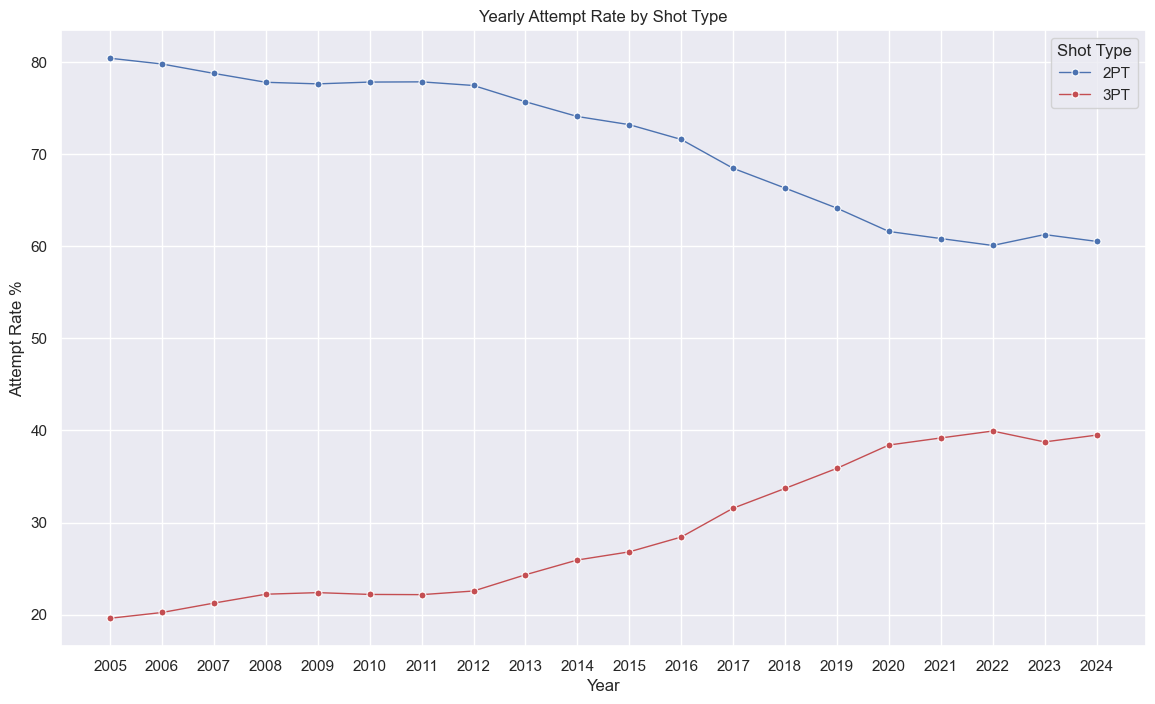

In [24]:
sns.set_theme(style="darkgrid", palette='deep')

plt.figure(figsize=(14,8))
sns.lineplot(x=attempt_rate.index, y=attempt_rate['2PTS'], color='b', marker='o', lw=1, markersize=5, label='2PT')
sns.lineplot(x=attempt_rate.index, y=attempt_rate['3PTS'], color='r', marker='o', lw=1, markersize=5, label='3PT')
plt.xlabel('Year')
plt.ylabel('Attempt Rate %')
plt.title('Yearly Attempt Rate by Shot Type')
plt.xticks(ticks=range(2005,2025, 1))
plt.legend(title='Shot Type')
plt.show()

We can see the steady rise of the ratio of 3-point attempts over the years, going from just under 20% in 2004-05 to nearly 40% of all shot attempts in 2023-2024.

A similar increase in the average distance to the basket is also expected.

In [25]:
distance_to_bskt=complete_dataframe.groupby('SEASON_1')['SHOT_DISTANCE'].mean()

In [26]:
distance_to_bskt

SEASON_1
2005    11.744102
2006    11.787442
2007    11.823580
2008    12.148333
2009    12.014892
2010    11.846472
2011    12.135647
2012    12.059812
2013    12.158762
2014    12.303381
2015    12.361002
2016    12.463743
2017    12.852874
2018    13.159593
2019    13.054780
2020    13.413617
2021    13.619573
2022    13.803979
2023    13.457748
2024    13.534607
Name: SHOT_DISTANCE, dtype: float64

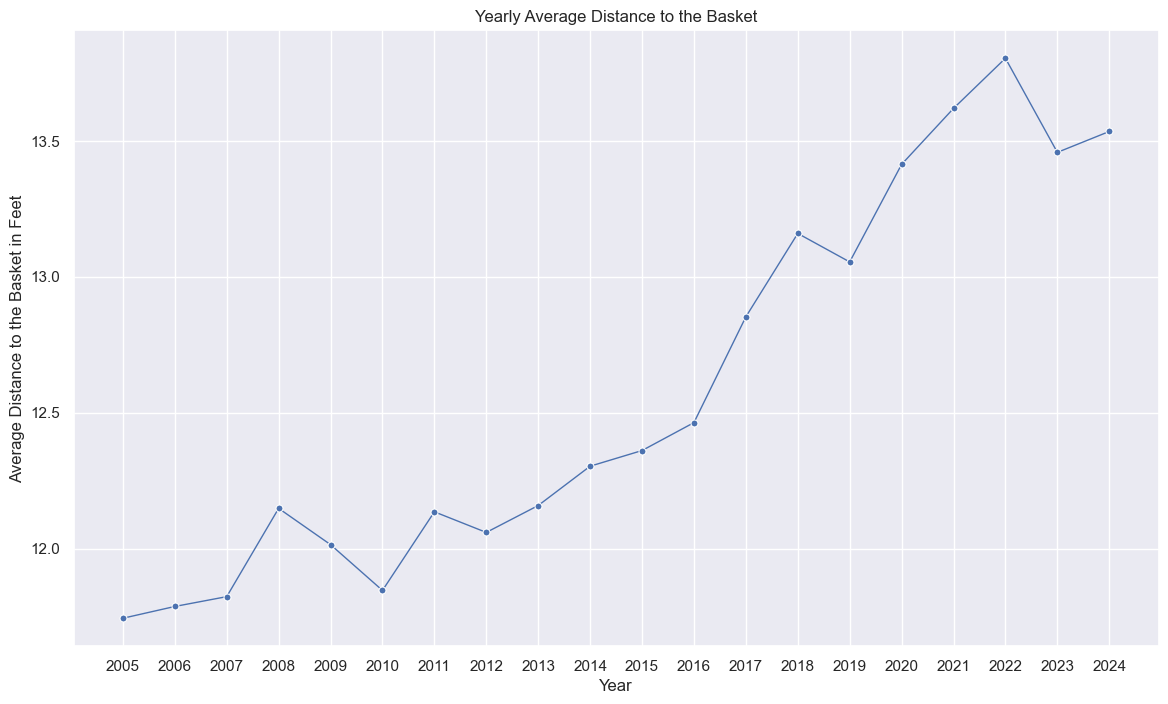

In [27]:
sns.set_theme(style="darkgrid", palette='deep')

plt.figure(figsize=(14,8))
sns.lineplot(x=distance_to_bskt.index, y=distance_to_bskt.values, color='b', marker='o', lw=1, markersize=5)
plt.xlabel('Year')
plt.ylabel('Average Distance to the Basket in Feet')
plt.title('Yearly Average Distance to the Basket')
plt.xticks(ticks=range(2005,2025, 1))
plt.show()

This begs the question, is the strategy successful? Does the increase in the ratio of 3-point shot attempts correspond to a higher points-per-attempt?

Points-per-attempt is an offensive efficiency metric used in the NBA to assess the quality of the offensive possession. it is calculated by dividing the total points by total attempts. 

First let's look at the actual success rate of the 3-shot and the two shot during the years.

In [28]:
mask0 = complete_dataframe['SHOT_TYPE']=='2PT Field Goal'
mask1 = complete_dataframe['SHOT_TYPE']=='3PT Field Goal'

two_vs_three = pd.concat([(complete_dataframe[mask0].groupby('SEASON_1')['SHOT_MADE'].apply(lambda x: x.sum() / x.count()) * 100).rename('2PTS'), +
            (complete_dataframe[mask1].groupby('SEASON_1')['SHOT_MADE'].apply(lambda x: x.sum() / x.count()) * 100).rename('3PTS') ], axis=1)

#SHOT_MADE is Boolean so the lambda function sums up all the successful shots and divides by the total attempts.

In [29]:
two_vs_three

,2PTS,3PTS
SEASON_1,,
2005,46.990773,35.555384
2006,47.793240,35.830387
2007,48.532069,35.818675
2008,48.439634,36.197917
2009,48.525613,36.679459
2010,49.184291,35.453710
2011,48.713315,35.848162
2012,47.684851,34.864605
2013,48.300796,35.883109


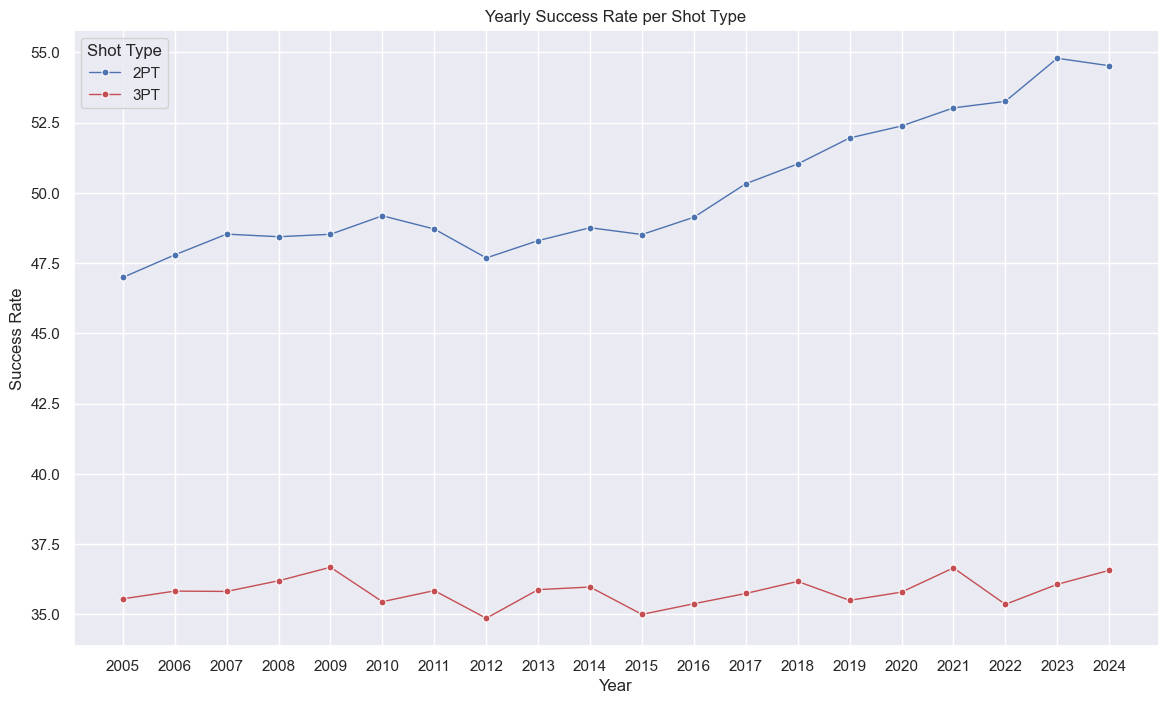

In [30]:
sns.set_theme(style="darkgrid", palette='deep')

plt.figure(figsize=(14,8))
sns.lineplot(x=two_vs_three.index, y=two_vs_three['2PTS'], color='b', marker='o', lw=1, markersize=5, label ='2PT')
sns.lineplot(x=two_vs_three.index, y=two_vs_three['3PTS'], color='r', marker='o', lw=1, markersize=5, label = '3PT')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.title('Yearly Success Rate per Shot Type')
plt.xticks(ticks=range(2005,2025, 1))
plt.legend(title='Shot Type')
plt.show()

We can see that the success rate of 3's is largely the same over the years. It is actually the two-point attempt shot that saw a massive increase in success during the time period.

We'll look at the actual points per attempt of the 3 shot and the regular 2-points shot during the years and see which shot results in more points on average.

In [31]:
mask0 = complete_dataframe['SHOT_TYPE']=='2PT Field Goal'
mask1 = complete_dataframe['SHOT_TYPE']=='3PT Field Goal'

points_per_attempt=pd.concat([(complete_dataframe[mask0].groupby('SEASON_1')['SHOT_MADE'].apply(lambda x: x.sum() / x.count()) * 2).rename('2PTS'), +
            (complete_dataframe[mask1].groupby('SEASON_1')['SHOT_MADE'].apply(lambda x: x.sum() / x.count()) * 3).rename('3PTS') ], axis=1)

#The lambda function returns the shot attempt success rate. 
#I multiply that by the number of points, 3 or 2, to see the actual expected points per attempt.

In [32]:
points_per_attempt

,2PTS,3PTS
SEASON_1,,
2005,0.939815,1.066662
2006,0.955865,1.074912
2007,0.970641,1.074560
2008,0.968793,1.085938
2009,0.970512,1.100384
2010,0.983686,1.063611
2011,0.974266,1.075445
2012,0.953697,1.045938
2013,0.966016,1.076493


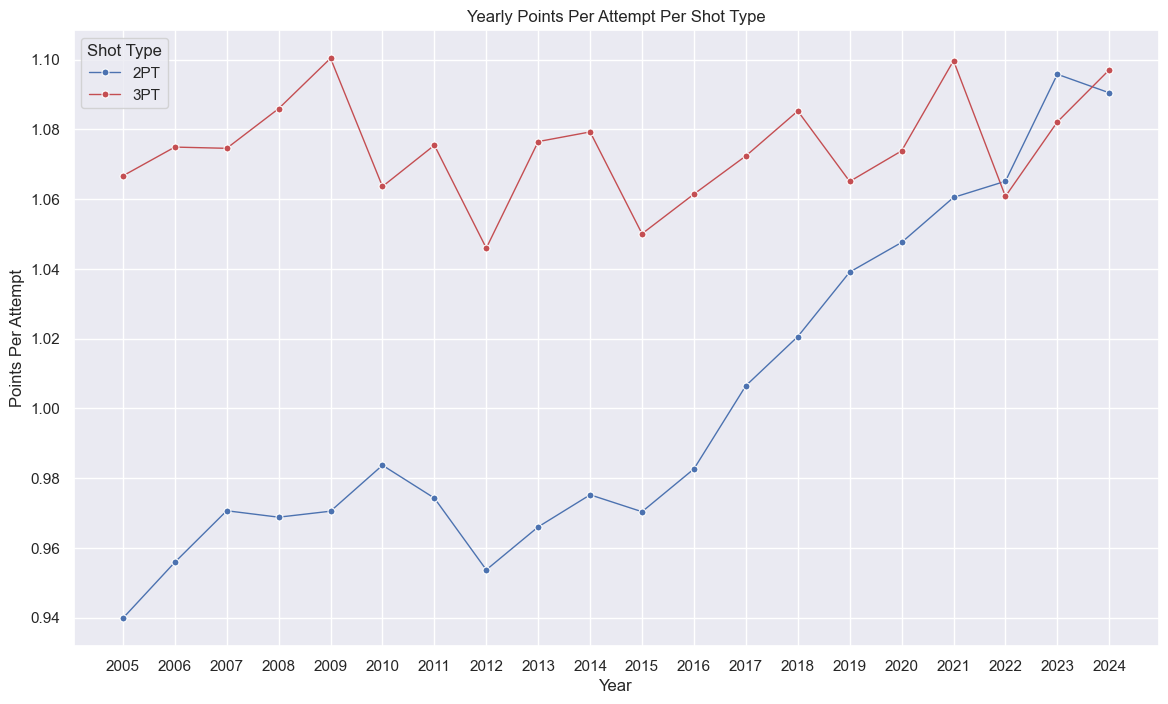

In [33]:
sns.set_theme(style="darkgrid", palette='deep')

plt.figure(figsize=(14,8))
sns.lineplot(x=points_per_attempt.index, y=points_per_attempt['2PTS'], color='b', marker='o', lw=1, markersize=5, label='2PT')
sns.lineplot(x=points_per_attempt.index, y=points_per_attempt['3PTS'], color='r', marker='o', lw=1, markersize=5, label='3PT')
plt.xlabel('Year')
plt.ylabel('Points Per Attempt')
plt.title('Yearly Points Per Attempt Per Shot Type')
plt.xticks(ticks=range(2005,2025, 1))
plt.legend(title='Shot Type')
plt.show()

We can see that the three-shot has always been more efficient than the two, even when the three was less often attempted. Only in later seasons, when the usage rate of the 3-point shot has reached nearly 40%, is when the points-per-attempt of the two-shot has reached parity with the 3-shot.

I will visualize the relative location(nba court zone name) of where 3's were attempted through the years with a heatmap. 

In [34]:
mask = complete_dataframe['SHOT_TYPE'] == '3PT Field Goal'
zone_points =complete_dataframe[mask].groupby(['SEASON_1','ZONE_NAME'])['Points'].sum().unstack()

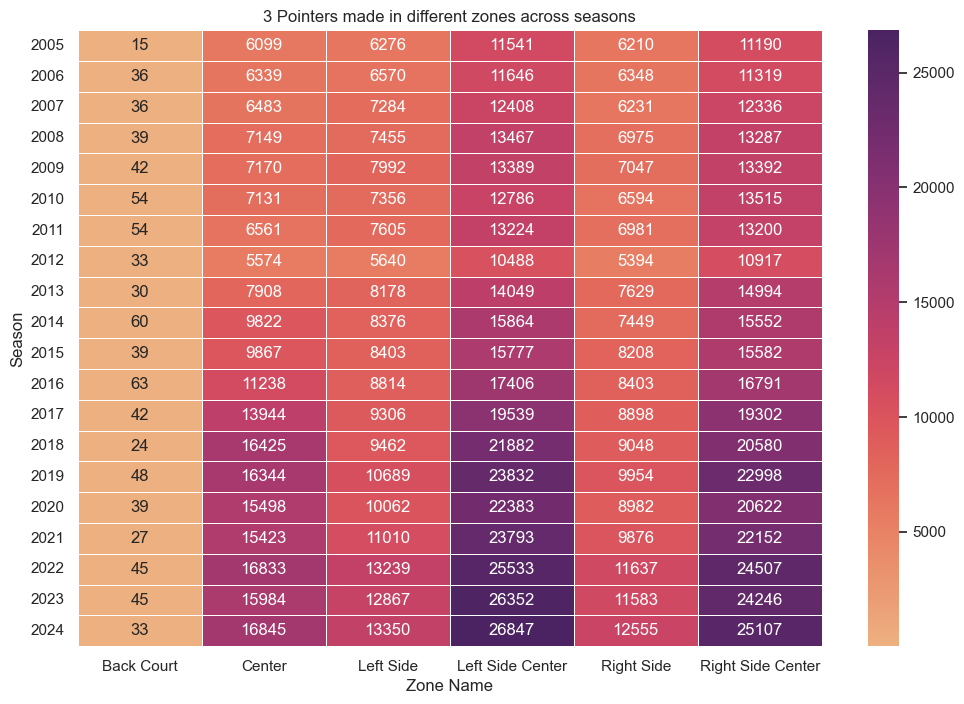

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(zone_points, annot=True, fmt='d', cmap='flare', lw=0.5)
plt.xlabel('Zone Name')
plt.ylabel('Season')
plt.title('3 Pointers made in different zones across seasons')
plt.show()

We can see the center shot overtaking the corner 3s(left/right side), while the the wings(left/right side center) remain the most dominant form of the 3 pointer.

Also apparent is the general increase in scoring, which we can also visualize.

In [36]:
zone_scoring = complete_dataframe.groupby(['SEASON_1','BASIC_ZONE'])['Points'].sum().unstack()

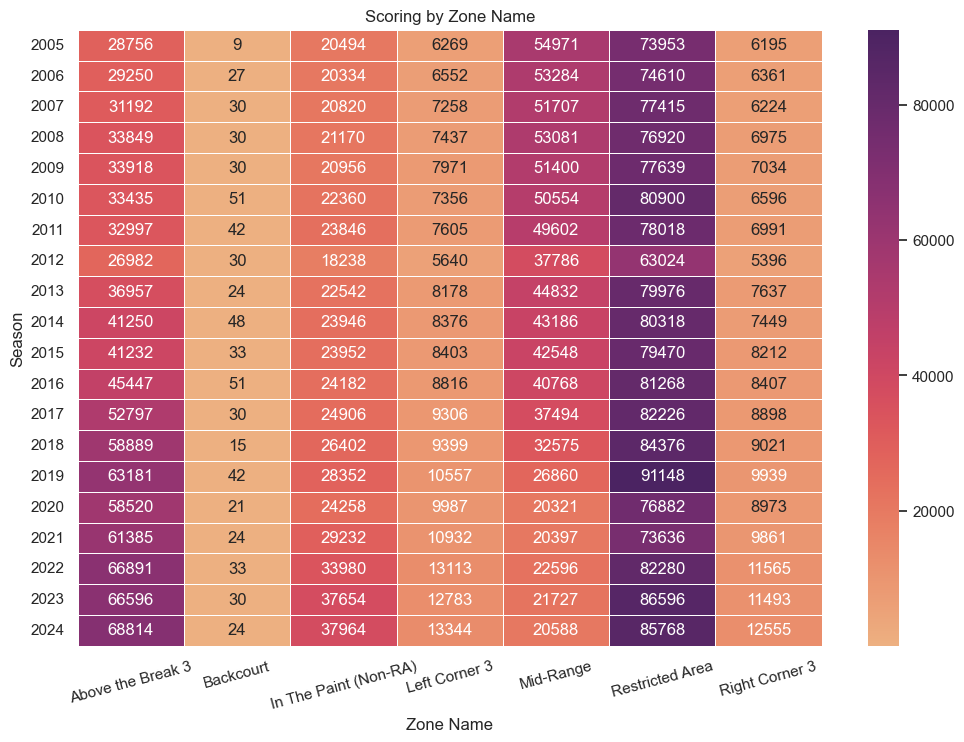

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(zone_scoring, annot=True, fmt='d', cmap='flare', lw=0.5)
plt.xlabel('Zone Name')
plt.xticks(rotation=15)
plt.ylabel('Season')
plt.title('Scoring by Zone Name')
plt.show()

Another thing to check is the actual trendline of scoring in the NBA during the years, segmented by shot type.

In [38]:
mask0 = complete_dataframe['SHOT_TYPE']=='2PT Field Goal'
mask1 = complete_dataframe['SHOT_TYPE']=='3PT Field Goal'

two_vs_three_points = pd.concat([(complete_dataframe[mask0].groupby('SEASON_1')['Points'].sum()).rename('2PTS'), +
            (complete_dataframe[mask1].groupby('SEASON_1')['Points'].sum()).rename('3PTS'), +
            (complete_dataframe.groupby('SEASON_1')['Points'].sum().rename('Total'))], axis=1)



In [39]:
two_vs_three_points

,2PTS,3PTS,Total
SEASON_1,,,
2005,149316,41331,190647
2006,148160,42258,190418
2007,149868,44778,194646
2008,151090,48372,199462
2009,149916,49032,198948
2010,153816,47436,201252
2011,151476,47625,199101
2012,119050,38046,157096
2013,147358,52788,200146


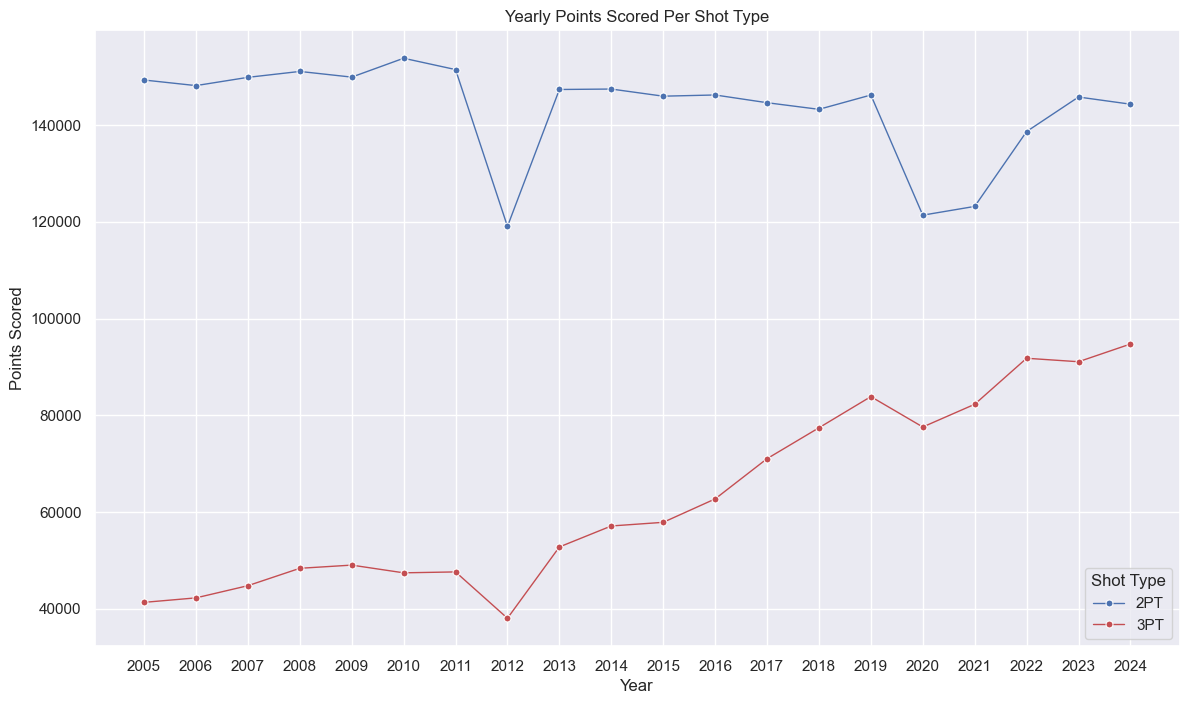

In [40]:
sns.set_theme(style="darkgrid", palette='deep')

plt.figure(figsize=(14,8))
sns.lineplot(x=two_vs_three_points.index, y=two_vs_three_points['2PTS'], color='b', marker='o', lw=1, markersize=5, label='2PT')
sns.lineplot(x=two_vs_three_points.index, y=two_vs_three_points['3PTS'], color='r', marker='o', lw=1, markersize=5, label='3PT')

plt.xlabel('Year')
plt.ylabel('Points Scored')
plt.title('Yearly Points Scored Per Shot Type')
plt.xticks(ticks=range(2005,2025, 1))
plt.legend(title='Shot Type')
plt.show()

Besides the strike year (2012) and the two covid years, we can see a general trendline of increasing scoring in the league and the increasing role 3-pointers are playing in scoring in the modern NBA, with the gap between scoring that resulted from a 3-pointer or a regular 2-point shot getting smaller every year.

Another interesting thing to consider is how the players approach the 3-point shot based on their position. For example, when did we start to see the rise centers, usually the tallest players on the team, who do not traditionally attempt 3 pointers, scoring more 3s.

In [41]:
mask = complete_dataframe['SHOT_TYPE'] == '3PT Field Goal'
position_threes = complete_dataframe[mask].groupby(['SEASON_1', 'POSITION_GROUP'])['Points'].sum().unstack()

In [42]:
position_threes

POSITION_GROUP,C,F,G
SEASON_1,,,
2005,759,15714,24858
2006,192,15624,26442
2007,915,16566,27297
2008,1500,17412,29460
2009,1104,19653,28275
2010,1443,17679,28314
2011,528,18135,28962
2012,342,13980,23724
2013,354,20781,31494


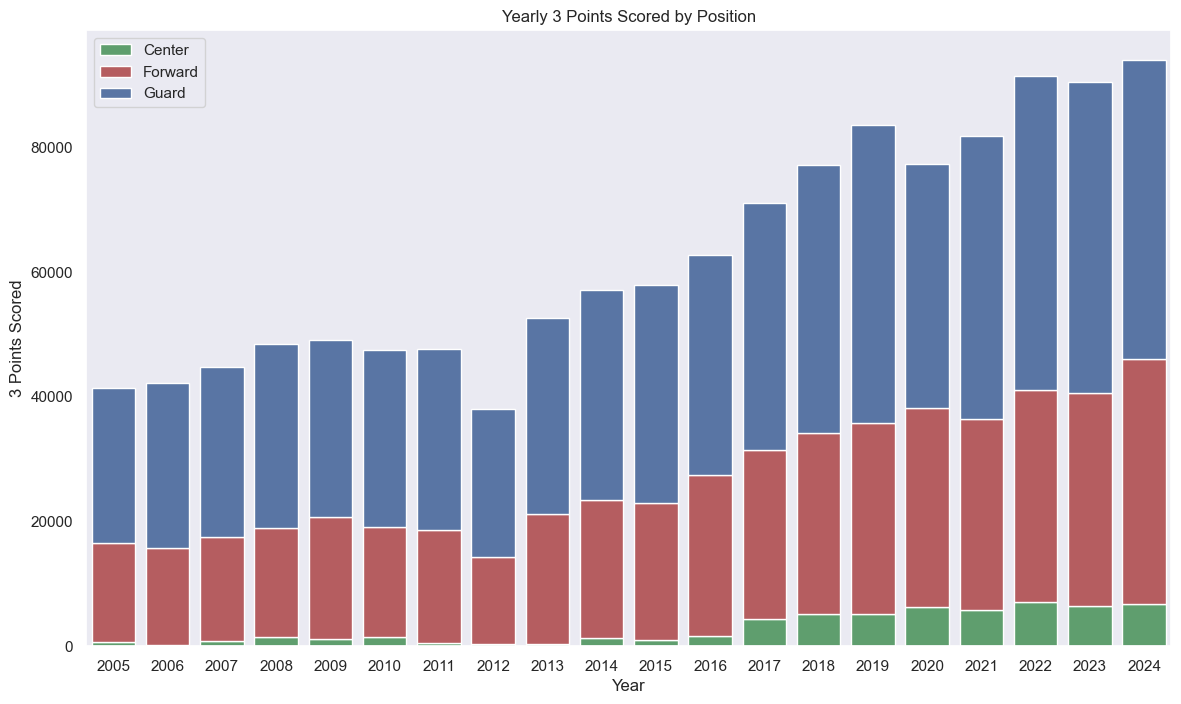

In [43]:
sns.set_theme(style="dark", palette='deep')

plt.figure(figsize=(14,8))

sns.barplot(x=position_threes.index, y=position_threes['C'], color='g', label='Center')
sns.barplot(x=position_threes.index, y=position_threes['F'], color='r', label='Forward', bottom=position_threes['C'])
sns.barplot(x=position_threes.index, y=position_threes['G'], color='b', label='Guard', bottom=position_threes['C'] + position_threes['F'])

plt.xlabel('Year')
plt.ylabel('3 Points Scored')
plt.title('Yearly 3 Points Scored by Position')
plt.show()

In 2017 we can see a massive increase in scored 3 pointers by centers, with the volume remaining mostly the same until 2024.

I will visualize this further using a scatterplot on a basketball court canvas.

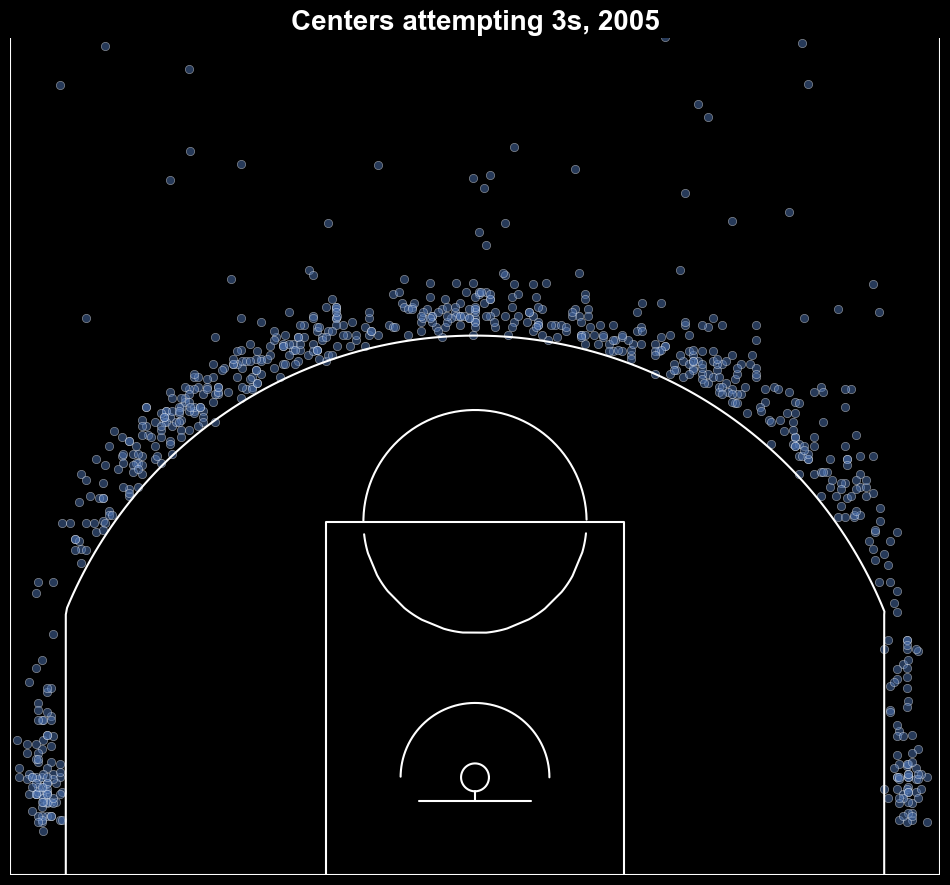

In [44]:
mask = (complete_dataframe['SEASON_1'] == 2005) & (complete_dataframe['POSITION_GROUP'] == 'C') & (complete_dataframe['SHOT_TYPE'] == '3PT Field Goal')

fig, ax = plt.subplots(figsize=(12, 11))
fig.patch.set_facecolor(court_themes['dark']['court'])

sns.scatterplot(data= complete_dataframe[mask] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['dark'])
ax.set_title('Centers attempting 3s, 2005', color='white', fontsize=20, fontweight = 'bold')
plt.show()

#The scatter plot draws individual shot attempts as dots
#I decided to avoid hueing the shots based on their success, as it will clutter the plot

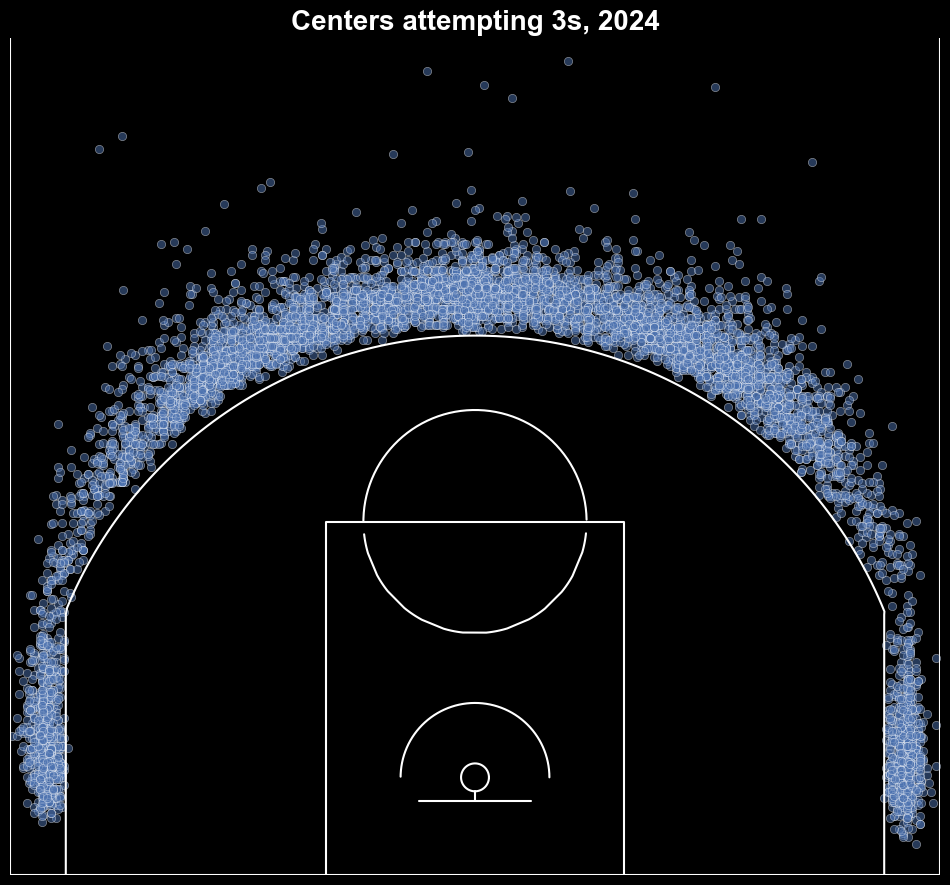

In [45]:
mask = (complete_dataframe['SEASON_1'] == 2024) & (complete_dataframe['POSITION_GROUP'] == 'C') & (complete_dataframe['SHOT_TYPE'] == '3PT Field Goal')

fig, ax = plt.subplots(figsize=(12, 11))
fig.patch.set_facecolor(court_themes['dark']['court'])

sns.scatterplot(data= complete_dataframe[mask] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['dark'])
ax.set_title('Centers attempting 3s, 2024', color='white', fontsize=20, fontweight = 'bold')
plt.show()


The visual difference is striking and paints a clear picture. Even the tallest players on the team, those who can usually score more effectively from close distance, have massively increased  their volume of 3 pointers.

**3 Points vs 2 Points conclusion**

The conclusion I reached here is that the 3-point shot was always more effective and efficient than the 2-point regular shot. The reason we see a rise in attempted 3s is because coaches and analytical departments in the NBA have pushed players to make analytically driven decisions on the court and increase the attempts of 3s in the game and to take less less low-quality 16-24 ft 2-pointers, which also leads to an increase in the percentage of 2-pointers.


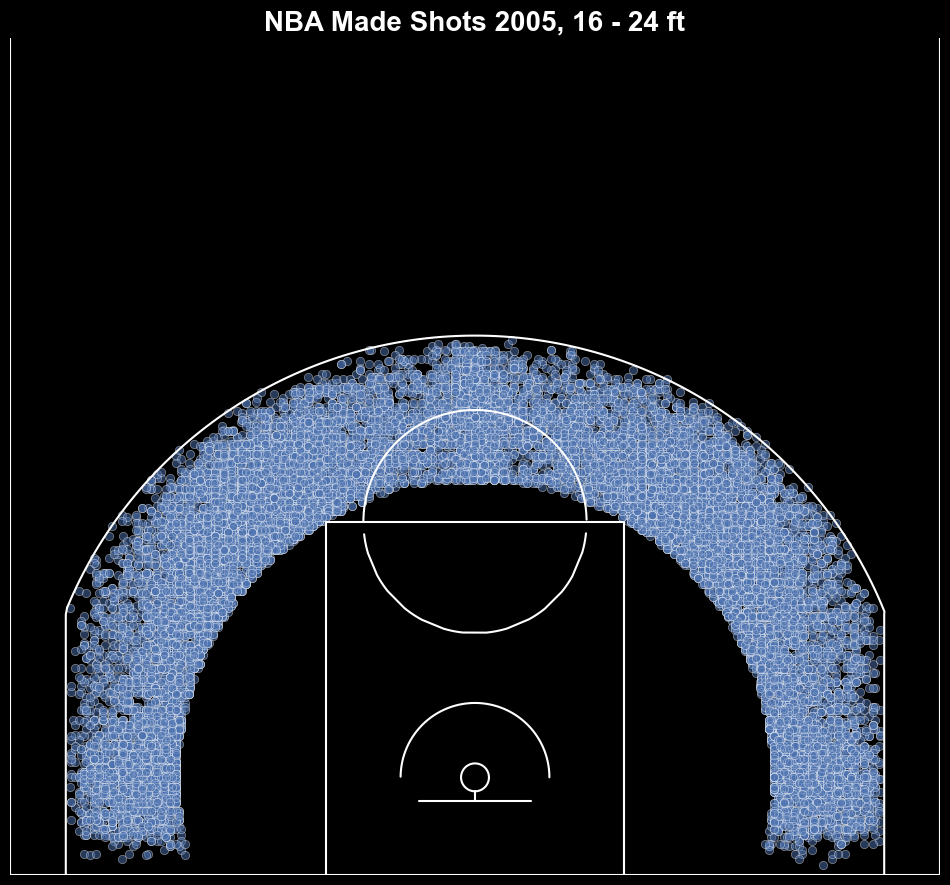

In [73]:
mask = (complete_dataframe['SEASON_1'] == 2005) & (complete_dataframe['SHOT_MADE'] == True) & (complete_dataframe['ZONE_RANGE'] == '16-24 ft.')

fig, ax = plt.subplots(figsize=(12, 11))
fig.patch.set_facecolor(court_themes['dark']['court'])


sns.scatterplot(data= complete_dataframe[mask] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['dark'])
ax.set_title('NBA Made Shots 2005, 16 - 24 ft', color='white', fontsize=20, fontweight = 'bold')
plt.show()

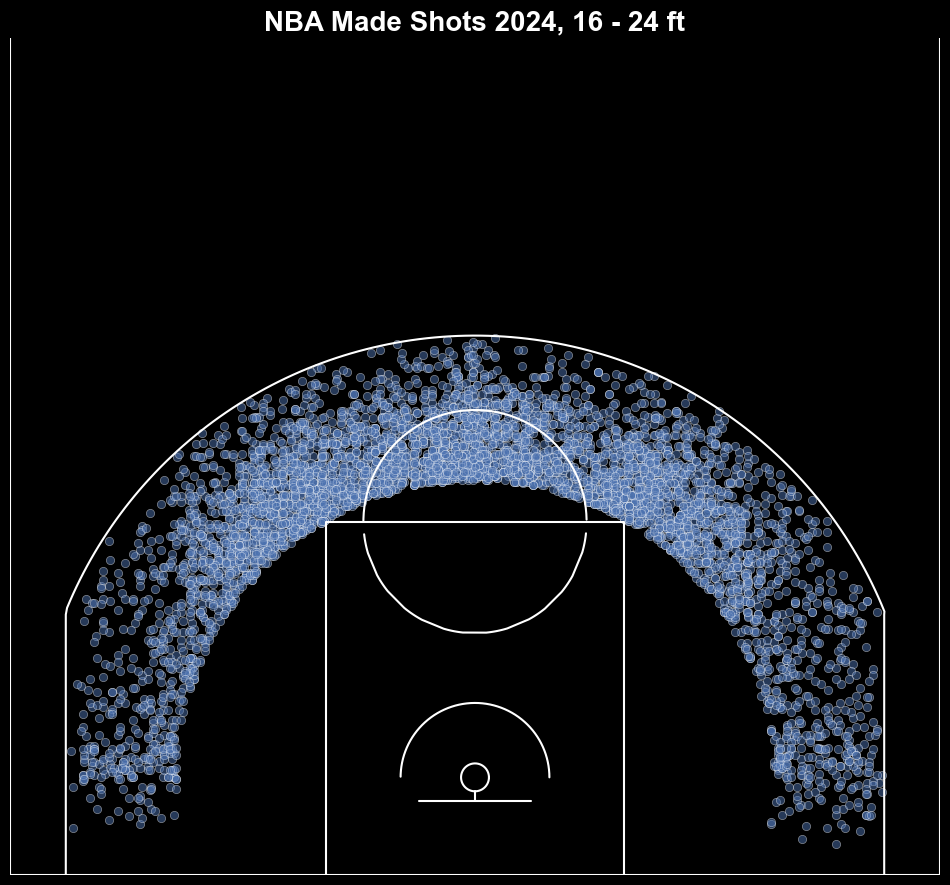

In [68]:
mask = (complete_dataframe['SEASON_1'] == 2024) & (complete_dataframe['SHOT_MADE'] == True) & (complete_dataframe['ZONE_RANGE'] == '16-24 ft.')


fig, ax = plt.subplots(figsize=(12, 11))
fig.patch.set_facecolor(court_themes['dark']['court'])


#sns.kdeplot(data= complete_dataframe[mask] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.3, fill=True, bw_adjust=0.2, hue='SHOT_MADE', palette=shot_made_palette)

sns.scatterplot(data= complete_dataframe[mask] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['dark'])
ax.set_title('NBA Made Shots 2024, 16 - 24 ft', color='white', fontsize=20, fontweight = 'bold')
plt.show()

**Genral overview of the last 19 years in the NBA**

A thing I want to know is who are the top 10 scorers(excluding free throws) in the NBA in the last 2 decades.

In [46]:
top_ten_scoring = complete_dataframe.groupby('PLAYER_NAME')['Points'].sum().nlargest(10)

In [47]:
top_ten_scoring

PLAYER_NAME
LeBron James         30777
Kevin Durant         21931
Carmelo Anthony      20652
Stephen Curry        19909
Russell Westbrook    19380
James Harden         18226
Chris Paul           17516
DeMar DeRozan        17411
Dirk Nowitzki        17379
LaMarcus Aldridge    16849
Name: Points, dtype: int64

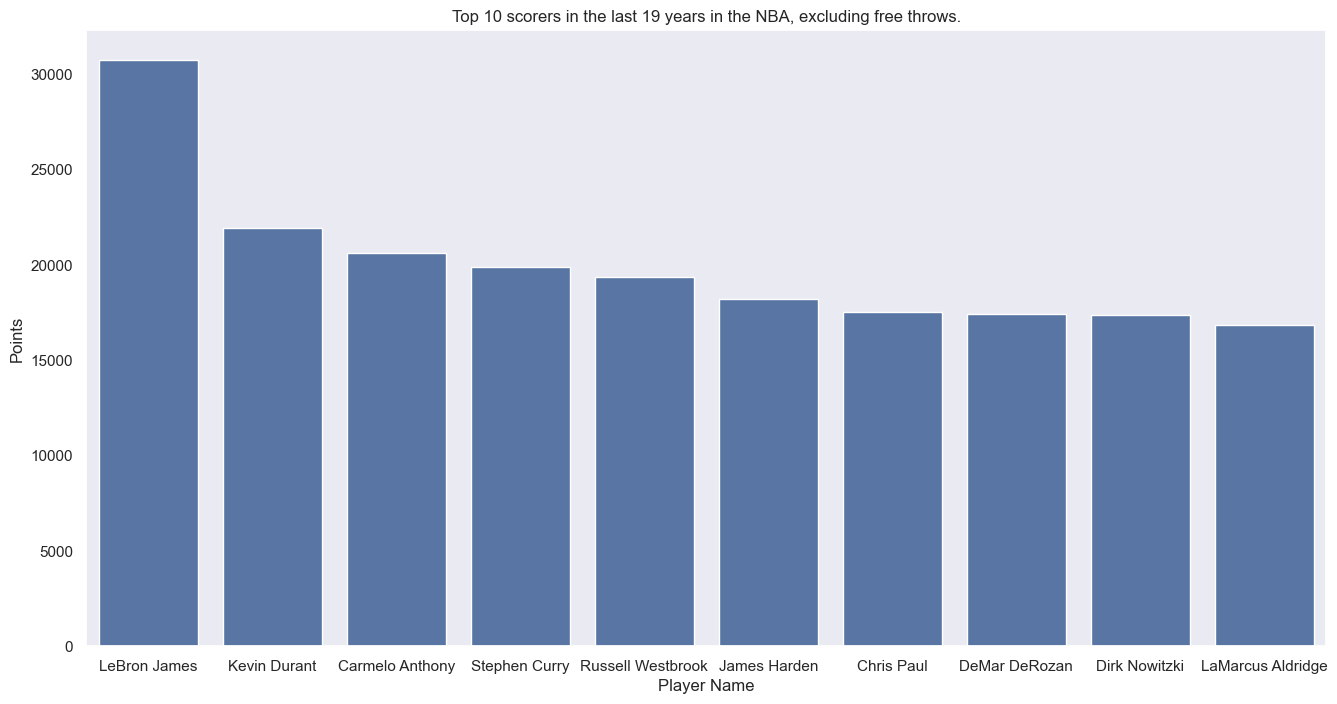

In [48]:
sns.set_theme(style="dark", palette='deep')

plt.figure(figsize=(16,8))

sns.barplot(x=top_ten_scoring.index, y=top_ten_scoring.values, color='b')

plt.xlabel('Player Name')
plt.ylabel('Points')
plt.title('Top 10 scorers in the last 19 years in the NBA, excluding free throws.')
plt.show()

In the NBA, traditionally Christmas games are the most highly watched games in the regular season and are somewhat removed from the normal game distribution amongst the teams. Only popular teams with popular players get slotted for Christmas games.

I'm wondering if the general scoring trend we see also applies to those specific games as well.


In [49]:
mask =(complete_dataframe['GAME_DATE'].dt.month == 12) & (complete_dataframe['GAME_DATE'].dt.day == 25)

top_ten_scoring_christmas = complete_dataframe[mask].groupby('PLAYER_NAME')['Points'].sum().nlargest(10)

In [50]:
top_ten_scoring_christmas

PLAYER_NAME
LeBron James         335
Dwyane Wade          234
Kevin Durant         230
Kobe Bryant          211
Russell Westbrook    203
James Harden         197
Carmelo Anthony      154
Kyrie Irving         143
Chris Paul           134
Klay Thompson        131
Name: Points, dtype: int64

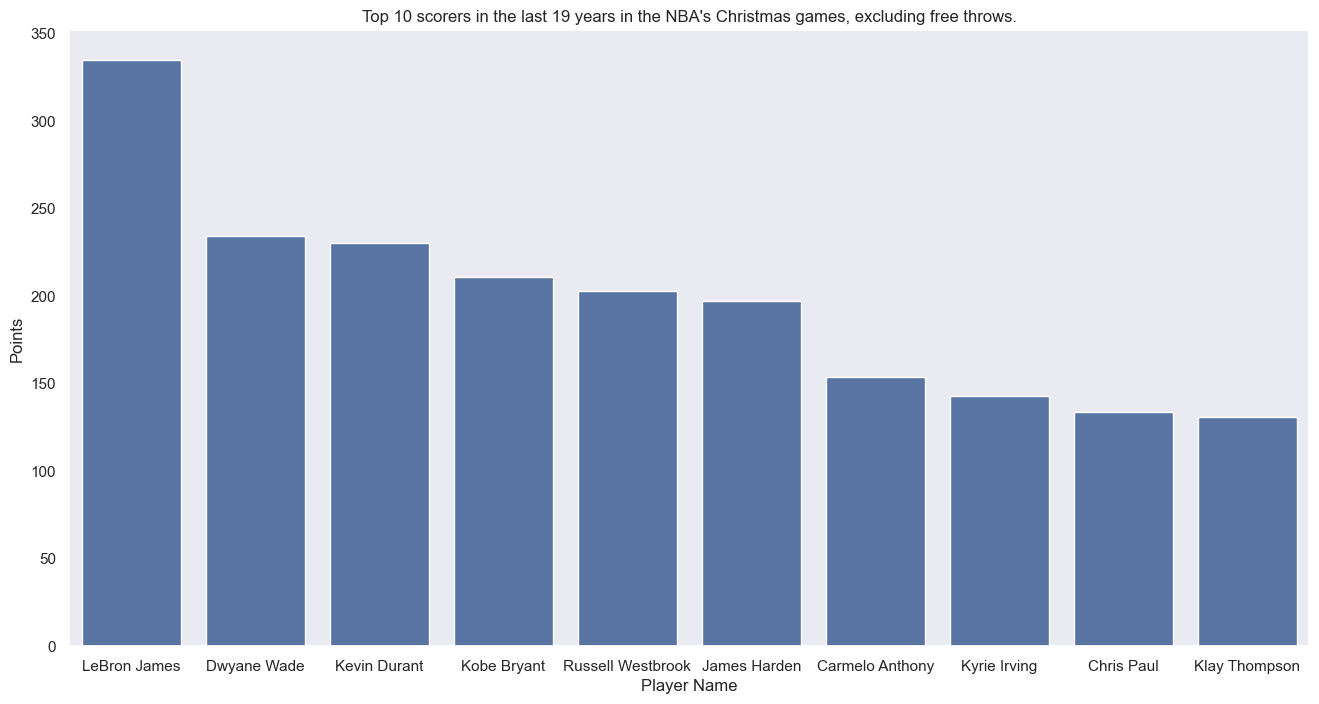

In [51]:
sns.set_theme(style="dark", palette='deep')

plt.figure(figsize=(16,8))

sns.barplot(x=top_ten_scoring_christmas.index, y=top_ten_scoring_christmas.values, color='b')

plt.xlabel('Player Name')
plt.ylabel('Points')
plt.title('Top 10 scorers in the last 19 years in the NBA\'s Christmas games, excluding free throws.')
plt.show()

We see LeBron James being the top general scorer in the league and the top scorer in the Christmas games. 

**LeBron James 2005 Vs 2024**

LeBron James, often hailed as one of the greatest basketball players of all time, has been playing in the NBA for over two decades. 

LeBron entered the NBA in 2003, drafted by the Cleveland Cavaliers. Over the years, he has played for the Miami Heat and the Los Angeles Lakers.

As of the 2024-2025 season, LeBron is the oldest player in the league.
LeBron achieved multiple accolades, including four NBA championships, four MVP awards, and 21 NBA All-Star selections.


Analyzing his career, particularly the earliest and the latest season in the data, can also provide insight into the way basketball has changed over the last two decades.

In [52]:
#getting his player ID
lebron_id = complete_dataframe['PLAYER_ID'][complete_dataframe['PLAYER_NAME'].str.lower() == 'lebron james'].values[0]

In [53]:
lebron_id

2544

In [54]:
#filtering to lebron only
lebron_data = complete_dataframe[complete_dataframe['PLAYER_ID'] == lebron_id].copy()

In [55]:
#creating some useful masks
lebron_2005 = lebron_data['SEASON_1'] == 2005
lebron_2024 = lebron_data['SEASON_1'] == 2024
lebron_clutch_time = (lebron_data['QUARTER'] >= 4) & (lebron_data['MINS_LEFT'] <= 4)
lebron_shot_made = lebron_data['SHOT_MADE'] == True
lebron_shot_missed = lebron_data['SHOT_MADE'] == False

First let's visualize LeBron's scoring in 2005 and 2024.

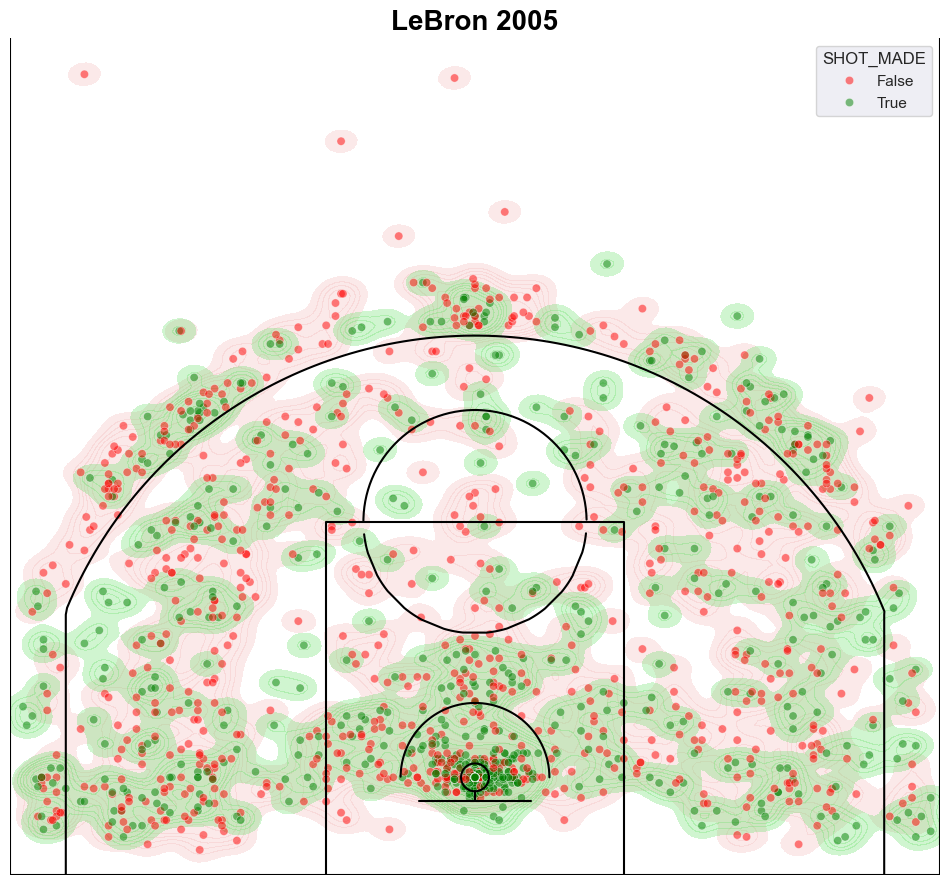

In [56]:
#2005
fig, ax = plt.subplots(figsize=(12, 11))

sns.kdeplot(data= lebron_data[lebron_2005] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.3, fill=True, bw_adjust=0.2, hue='SHOT_MADE', palette=shot_made_palette)

sns.scatterplot(data= lebron_data[lebron_2005] ,x='LOC_X', y='LOC_Y', ax=ax, hue='SHOT_MADE',
                palette=shot_made_palette, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['light'])
ax.set_title('LeBron 2005', color='black', fontsize=20, fontweight = 'bold')
plt.show()


#The KDE plot draws heat zones based on the amount of shot attempts at a particular coordinate,
#and then colors it based on whether the location result in more made shots or missed shots.

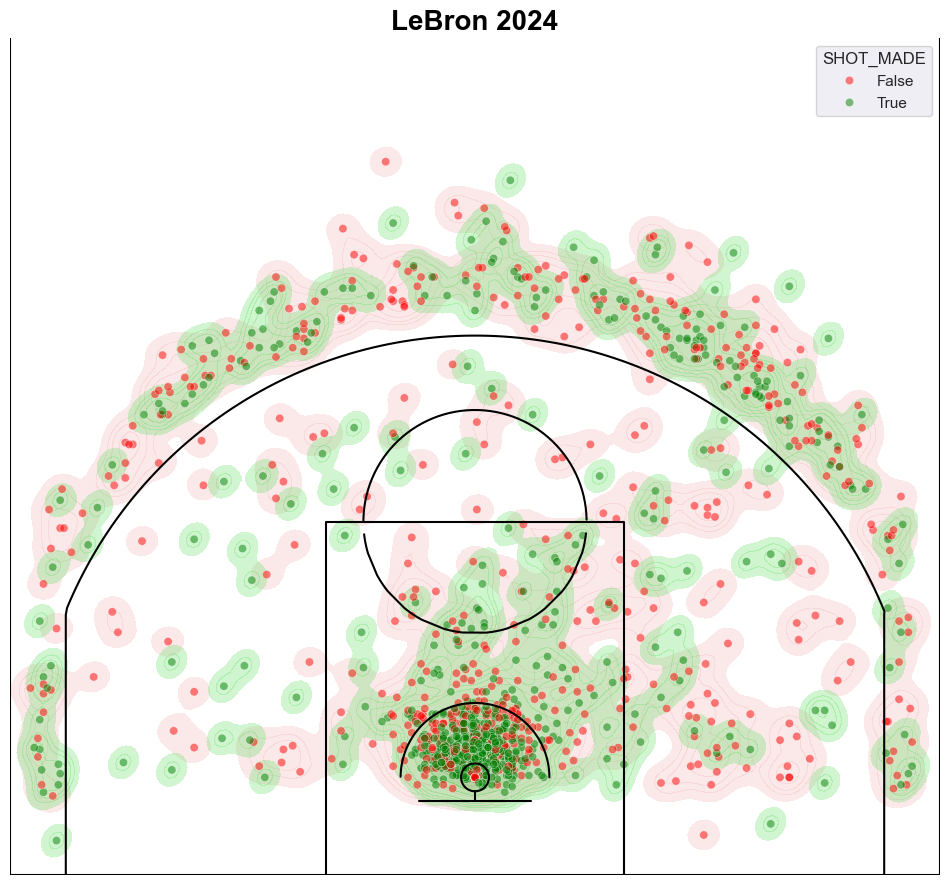

In [57]:
#2024
fig, ax = plt.subplots(figsize=(12, 11))

sns.kdeplot(data= lebron_data[lebron_2024] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.3, fill=True, bw_adjust=0.2, hue='SHOT_MADE', palette=shot_made_palette)

sns.scatterplot(data= lebron_data[lebron_2024] ,x='LOC_X', y='LOC_Y', ax=ax, hue='SHOT_MADE',
                palette=shot_made_palette, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['light'])
ax.set_title('LeBron 2024', color='black', fontsize=20, fontweight = 'bold')
plt.show()

What is immediately apparent is the "tightening" of LeBron's shot selection, you can see him taking significantly less mid-range shots and focusing mostly on close to the basket high percentage shots and 3 pointers in 2024 compared to 2005. A tend that the entire league is following as well.

Also, LeBron seems to mostly abandon the right side(his perspective, on the left in the canvas) of the court.

It's interesting to see if the different shot selection is also apparent during clutch time.

In the NBA, "clutch time" is the last 5 minutes in the last quarter of the game, when the game is on the line.


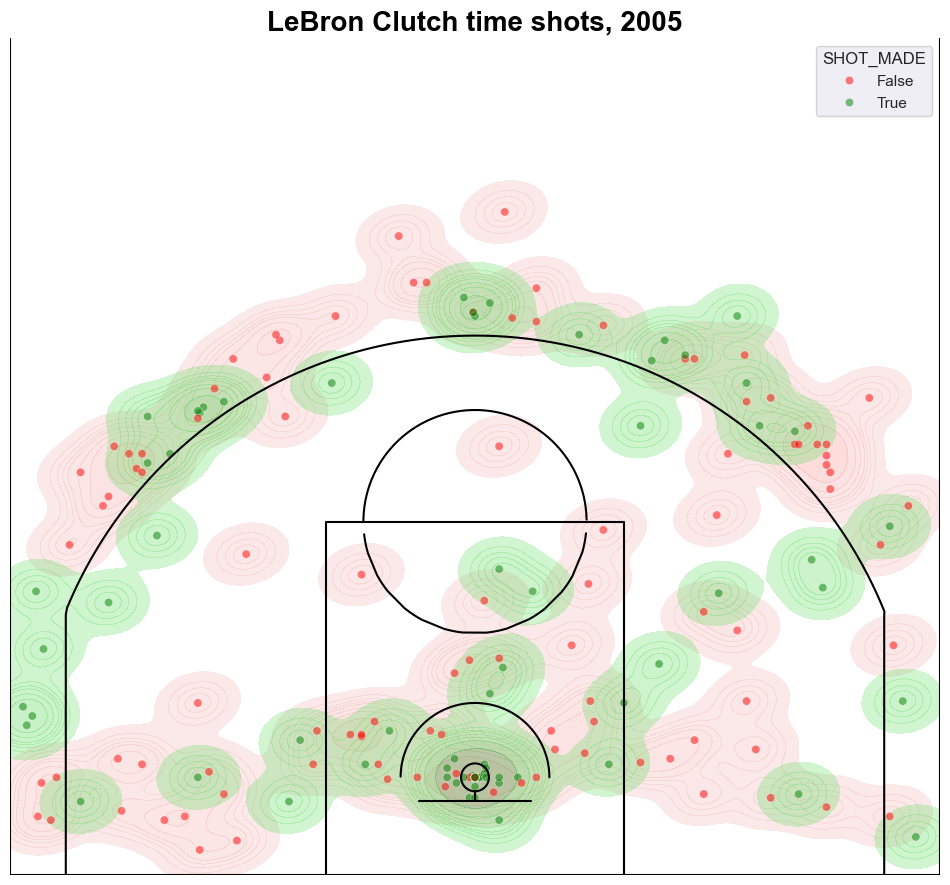

In [58]:
#Clutch 2005
fig, ax = plt.subplots(figsize=(12, 11))

sns.kdeplot(data= lebron_data.loc[lebron_clutch_time & lebron_2005] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.3, fill=True, bw_adjust=0.2, hue='SHOT_MADE', palette=shot_made_palette)

sns.scatterplot(data= lebron_data.loc[lebron_clutch_time & lebron_2005] ,x='LOC_X', y='LOC_Y', ax=ax, hue='SHOT_MADE',
                palette=shot_made_palette, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['light'])
ax.set_title('LeBron Clutch time shots, 2005', color='black', fontsize=20, fontweight = 'bold')
plt.show()

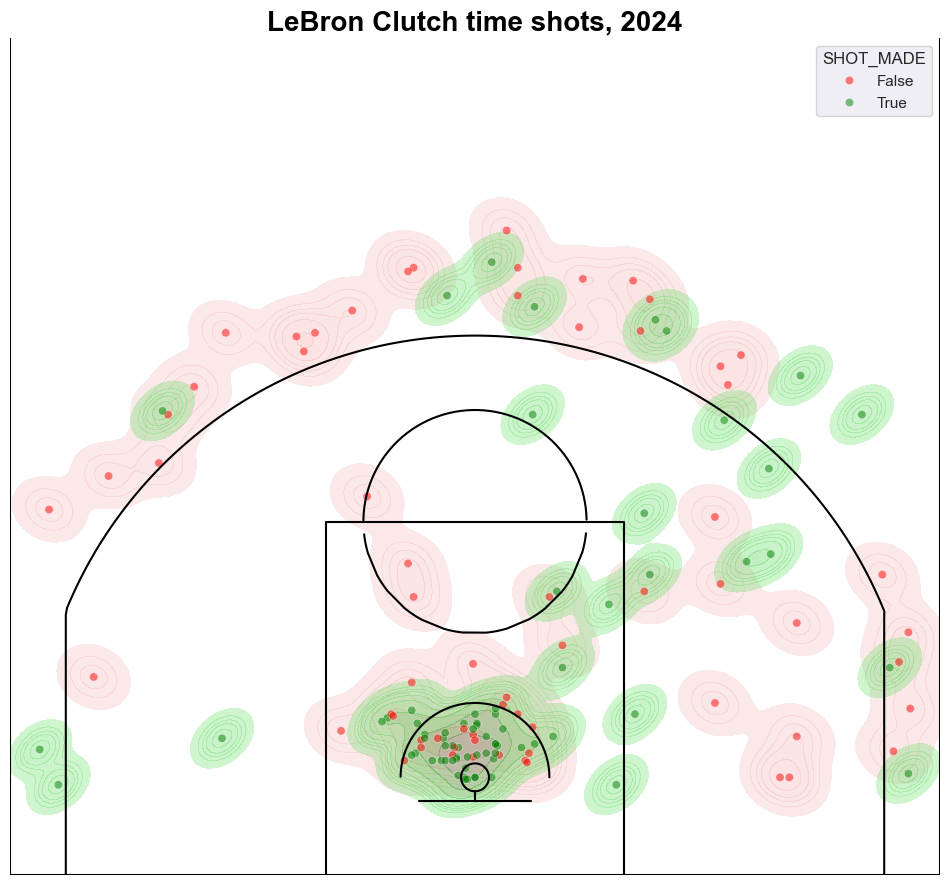

In [59]:
#Clutch 2024
fig, ax = plt.subplots(figsize=(12, 11))

sns.kdeplot(data= lebron_data.loc[lebron_clutch_time & lebron_2024] ,x='LOC_X', y='LOC_Y', ax=ax, alpha=0.3, fill=True, bw_adjust=0.2, hue='SHOT_MADE', palette=shot_made_palette)

sns.scatterplot(data= lebron_data.loc[lebron_clutch_time & lebron_2024] ,x='LOC_X', y='LOC_Y', ax=ax, hue='SHOT_MADE',
                palette=shot_made_palette, alpha=0.5)

plot_court(ax=ax, court_theme=court_themes['light'])
ax.set_title('LeBron Clutch time shots, 2024', color='black', fontsize=20, fontweight = 'bold')
plt.show()

In the clutch as well, we can see LeBron effectively giving up on the right side of the court and significantly tightening his shot selection.

We see there's a marked difference in the way LeBron has approached the offensive side of the court in 2005 and 2024. Taking more high-quality shots and reducing the amount of shots that are close to the 3 point line, but are not actually 3s. 
This can also be seen as the general trendline of the league as a whole, taking less low quality contested mid-range shots and focusing on high percentage close to the basket attempts and high points-per-attempt 3-point shots.